In [1]:
# Tutorial: https://github.com/terrier-org/cikm2021tutorial/tree/main
import os
import pandas as pd
import pyterrier as pt
import matplotlib.pyplot as plt

In [2]:
if not pt.started():
    pt.init()

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [3]:
# Importamos un dataset (corpus) desde el repo de pyTerrier: https://pyterrier.readthedocs.io/en/latest/datasets.html
#
dataset_name = "vaswani"
dataset = pt.datasets.get_dataset(dataset_name)

### Parte 1 - Explorar el corpus

In [4]:
# Obtenemos el archivo de documentos
dataset.get_corpus()

# Pasamos los documentos a un dataframe
documents = dataset.get_corpus_iter()
df = pd.DataFrame(documents)

In [5]:
df.shape

(11429, 2)

In [6]:
df.head()

,docno,text
0,1,compact memories have flexible capacities a d...
1,2,an electronic analogue computer for solving sy...
2,3,electronic coordinate transformer circuit det...
3,4,the british computer society report of a conf...
4,5,millimicrosecond digital computer logic a sys...


### Parte 2 - Indexar el corpus con pyTerrier

In [7]:
#
index_path = "./vaswani_index"

if os.path.exists(index_path):
    index = pt.IndexFactory.of(index_path+"/data.properties")
else:
    indexer  = pt.TRECCollectionIndexer(index_path, blocks=True)
    indexref = indexer.index(dataset.get_corpus())
    index = pt.IndexFactory.of(indexref)


In [8]:
# Obtenemos estadísticas del índice
print(index.getCollectionStatistics().toString())

Number of documents: 11429
Number of terms: 7756
Number of postings: 224573
Number of fields: 0
Number of tokens: 271581
Field names: []
Positions:   true



**Exploramos el diccionario (lexicon)**  

In [9]:
# Obtenemos el diccionario
lex = index.getLexicon()

# Salida:
# término -> id, Nt, TF, maxTF, @
#
# donde:
#       Nt es el DF, número de docs donde aparece el término (sirve para calcular el IDF).
#       TF es la suma de los Tfs de los Nt docs.
#       maxTF es el número total de ocurrencias del término.
#       Los números entre @{} son punteros para Terrier.

for i, kv in enumerate(lex):
    print("%s -> %s" % (kv.getKey(), kv.getValue().toString()))
    #print(kv.getFrequency())
    if (i > 10): break

aa -> term318 Nt=5 TF=5 maxTF=1 @{0 0 0}
aachen -> term3072 Nt=1 TF=1 maxTF=1 @{0 16 1}
aad -> term1784 Nt=2 TF=2 maxTF=1 @{0 20 2}
aan -> term3885 Nt=2 TF=2 maxTF=1 @{0 27 4}
ab -> term2352 Nt=6 TF=6 maxTF=1 @{0 32 6}
abac -> term3257 Nt=3 TF=5 maxTF=3 @{0 55 6}
abandon -> term6096 Nt=1 TF=1 maxTF=1 @{0 70 1}
abbrevi -> term6509 Nt=3 TF=3 maxTF=1 @{0 74 6}
abd -> term5292 Nt=1 TF=1 maxTF=1 @{0 82 3}
abel -> term5204 Nt=2 TF=2 maxTF=1 @{0 86 4}
aber -> term4071 Nt=1 TF=1 maxTF=1 @{0 95 6}
aberr -> term2390 Nt=7 TF=10 maxTF=4 @{0 100 1}


In [10]:
# Obtener el término a partir de un id
termid = 3257
#
lee  = lex.getLexiconEntry(termid)
term = lee.getKey()
print (termid, term)

3257 abac


**Exploramos posting lists y documentos en el índice**

In [11]:
# Obtner la posting list del término ´x´
pointer = index.getLexicon()[term]
for posting in index.getInvertedIndex().getPostings(pointer):
    print(posting.toString() + " doclen = %d" % posting.getDocumentLength())

(1748,1,B[17]) doclen = 30
(4921,3,B[0,17,27]) doclen = 34
(7192,1,B[29]) doclen = 33


In [12]:
# Términos en un doc
di  = index.getDirectIndex()
doi = index.getDocumentIndex()
lex = index.getLexicon()
#
docid = 9127
#
for posting in di.getPostings(doi.getDocumentEntry(docid)):
    termid = posting.getId()
    lee    = lex.getLexiconEntry(termid)
    print("Término '%s', TF = %d" % (lee.getKey(), posting.getFrequency()))

Término 'june', TF = 1
Término 'fast', TF = 1
Término 'delai', TF = 1
Término 'relat', TF = 1
Término 'mai', TF = 1
Término 'posit', TF = 1
Término 'magnet', TF = 1
Término 'field', TF = 1
Término 'strong', TF = 1
Término 'time', TF = 1
Término 'long', TF = 1
Término 'period', TF = 1
Término 'rang', TF = 1
Término 'observ', TF = 1
Término 'emiss', TF = 3
Término 'continuum', TF = 1
Término 'involv', TF = 1
Término 'veloc', TF = 1
Término 'particl', TF = 1
Término 'wavelength', TF = 1
Término 'show', TF = 1
Término 'see', TF = 1
Término 'radio', TF = 1
Término 'atmospher', TF = 1
Término 'solar', TF = 3
Término 'correl', TF = 1
Término 'februari', TF = 1
Término 'januari', TF = 1
Término 'boulder', TF = 1
Término 'activ', TF = 1
Término 'jupit', TF = 2
Término 'dai', TF = 1
Término 'planet', TF = 1


### Parte 3 - Ejecutar un experimento de recuperación (y evaluación)

In [13]:
# Obtenemos los 'topics'
topics = dataset.get_topics()
topics

,qid,query
0,1,measurement of dielectric constant of liquids ...
1,2,mathematical analysis and design details of wa...
2,3,use of digital computers in the design of band...
3,4,systems of data coding for information transfer
4,5,use of programs in engineering testing of comp...
...,...,...
88,89,tunnel diode construction and its electrical c...
89,90,electronic density of states at the surface of...
90,91,resistivity of metallic thin films related to ...
91,92,the phenomenon of radiation caused by charged ...


In [14]:
# Obtenemos los 'qrels'
qrels = dataset.get_qrels()
qrels

,qid,docno,label
0,1,1239,1
1,1,1502,1
2,1,4462,1
3,1,4569,1
4,1,5472,1
...,...,...,...
2078,93,9875,1
2079,93,9956,1
2080,93,10497,1
2081,93,11191,1


**Definimos modelos de recuperación a usar**

In [15]:
# Búsquedas (más modelos en: http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html)
model_tf    = pt.BatchRetrieve(index, wmodel="Tf")
model_tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
model_bm25  = pt.BatchRetrieve(index, wmodel="BM25")
model_dlm   = pt.BatchRetrieve(index, wmodel="DirichletLM") 

**Ejecutamos una búsqueda**

In [16]:
#%%timeit
# Primero con con bm25 como modelo de RI
model_bm25.search("chemical document")

,qid,docid,docno,rank,score,query
0,1,2788,2789,0,15.635925,chemical document
1,1,10702,10703,1,13.472012,chemical document
2,1,3109,3110,2,12.958272,chemical document
3,1,1055,1056,3,12.517082,chemical document
4,1,4885,4886,4,12.228161,chemical document
5,1,6278,6279,5,11.185223,chemical document
6,1,1139,1140,6,10.740657,chemical document
7,1,8765,8766,7,10.740657,chemical document
8,1,10138,10139,8,10.527225,chemical document
9,1,2519,2520,9,10.322110,chemical document


In [17]:
# Ahora con con con dlm como modelo de RI
model_dlm.search("chemical document")

,qid,docid,docno,rank,score,query
0,1,2788,2789,0,5.774704,chemical document
1,1,3109,3110,1,4.805128,chemical document
2,1,6174,6175,2,4.790875,chemical document
3,1,6278,6279,3,3.484616,chemical document
4,1,10702,10703,4,2.623083,chemical document
5,1,1055,1056,5,2.621356,chemical document
6,1,4885,4886,6,2.620781,chemical document
7,1,1139,1140,7,2.617335,chemical document
8,1,8765,8766,8,2.617335,chemical document
9,1,10138,10139,9,2.616761,chemical document


In [18]:
# Varios queries (a partir de un DF)
many_queries = pd.DataFrame([["q1", "chemical document"], ["q2", "first document"]], columns=["qid", "query"])
model_bm25.transform(many_queries)
model_bm25(many_queries)

,qid,docid,docno,rank,score,query
0,q1,2788,2789,0,15.635925,chemical document
1,q1,10702,10703,1,13.472012,chemical document
2,q1,3109,3110,2,12.958272,chemical document
3,q1,1055,1056,3,12.517082,chemical document
4,q1,4885,4886,4,12.228161,chemical document
...,...,...,...,...,...,...
242,q2,4855,4856,219,3.035656,first document
243,q2,6325,6326,220,3.035656,first document
244,q2,5527,5528,221,2.826883,first document
245,q2,3732,3733,222,2.732907,first document


In [19]:
many_queries

,qid,query
0,q1,chemical document
1,q2,first document


### Parte 4 - Experimentos completos de Recuperación y Evaluación

In [20]:
# Un "Experiment" se define a partir de los modelos que queremos evaluar y los datos a usar. 
# Más opciones: https://pyterrier.readthedocs.io/en/latest/experiments.html

pt.Experiment(
    [model_bm25, model_dlm],                           # Que estamos evaluando? (modelos)
    dataset.get_topics(),                              # Qué queries usamos?
    dataset.get_qrels(),                               # Qué juicios de relevancia?
    eval_metrics=[ "P_5", "recall_10", "map", "ndcg_cut_10"]                    # Qué métricas vamos a usar?
)

,name,P_5,recall_10,map,ndcg_cut_10
0,BR(BM25),0.460215,0.218513,0.296517,0.446609
1,BR(DirichletLM),0.288172,0.153779,0.196005,0.297378


**Ejecutar un experimento comparando precisión en varios valores de k**

In [21]:
rs = pt.Experiment(
    [model_tf, model_bm25, model_dlm],                           # Que estamos evaluando? (modelos)
    dataset.get_topics(),                              # Qué queries usamos?
    dataset.get_qrels(),                               # Qué juicios de relevancia?
    # baseline = 0,
    # perquery = True,
    names=["TF", "BM25", "DLM"],
    eval_metrics=[ "P"]                    # Qué métricas vamos a usar?
)

In [22]:
rs

,name,P@5,P@10,P@15,P@20,P@30,P@100,P@200,P@500,P@1000
0,TF,0.210753,0.194624,0.172043,0.153763,0.144803,0.089892,0.063548,0.034753,0.020204
1,BM25,0.460215,0.352688,0.302509,0.269892,0.236918,0.126667,0.077903,0.037978,0.020828
2,DLM,0.288172,0.239785,0.219355,0.198925,0.167742,0.103333,0.071129,0.035763,0.020247


In [23]:
df = rs.T
df.columns = list(df.values[:1])
df = df.drop(df[df.index == "name"].index)
df.columns = ["TF", "BM25", "DLM"]
df.rank = [5, 10, 15, 20, 30, 100, 200, 500, 1000]

In [24]:
df

,TF,BM25,DLM
P@5,0.210753,0.460215,0.288172
P@10,0.194624,0.352688,0.239785
P@15,0.172043,0.302509,0.219355
P@20,0.153763,0.269892,0.198925
P@30,0.144803,0.236918,0.167742
P@100,0.089892,0.126667,0.103333
P@200,0.063548,0.077903,0.071129
P@500,0.034753,0.037978,0.035763
P@1000,0.020204,0.020828,0.020247


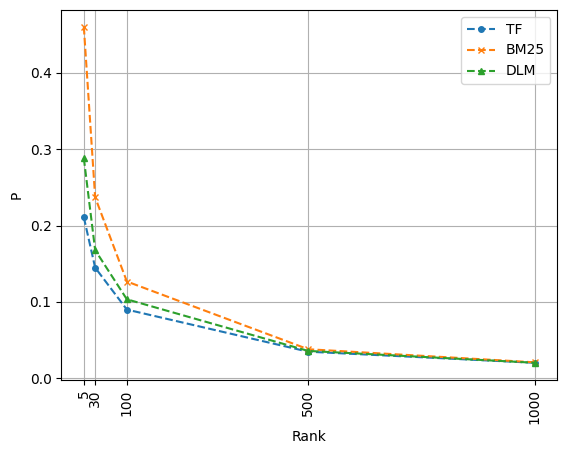

In [25]:
sel_rank = [5, 30, 100, 500, 1000]

sel_index = ['P@'+str(x) for x in sel_rank] 
#
tf_performance   = df['TF'].loc[sel_index]
bm25_performance = df['BM25'].loc[sel_index]
dlm_performance  = df['DLM'].loc[sel_index]
#
plt.plot(sel_rank, tf_performance,   'o--', markersize=4, label="TF")
plt.plot(sel_rank, bm25_performance, 'x--', markersize=4, label="BM25")
plt.plot(sel_rank, dlm_performance,  '^--', markersize=4, label="DLM")

#
plt.grid()
plt.xlabel("Rank")
plt.ylabel("P")
#
locs, labels = plt.xticks(sel_rank, rotation=90)
plt.legend(loc=1)
plt.show()

### Tarea 
**1) Ejecutar todo el set de consultas y calcular las principales métricas para k=[1, 5, 10, 50, 100]**

**2) Ejecute el experimento separando los resultados query por query (perquery = True) y determine si el modelo 'ganador' (puede probar R y P) en promedio es el mismo para todos consideranto k = 10.**